# Model Governance & Documentation.

In a real financial institution, this is the document you hand to the Model Risk Management (MRM) team or the Federal Regulators to get approval to go live. It summarizes what you built, how it works, and where it might fail.

This notebook uses a mix of Markdown (for documentation) and Code (for dynamic introspection of your saved models).

In [ ]:
import sys

sys.path.append("..")

import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.pricing_engine import LoanPricingEngine
import warnings

warnings.filterwarnings("ignore")

# Initialize Engine for Inspection
engine = LoanPricingEngine(
    risk_model_path="../models/risk_model_xgb.pkl",
    elasticity_model_path="../models/elasticity_model_logit.pkl",
)

print("✅ Model Governance Notebook Initialized")

✅ Model Governance Notebook Initialized


## Model Governance Report: Adaptive Pricing Engine

| **Project Name** | Adaptive Loan Pricing Engine (ALPE) |
| --- | --- |
| **Model Owner** | Data Science Team |
| **Model Type** | Hybrid (XGBoost Classification + Logistic Regression + Constrained Optimization) |
| **Purpose** | To optimize interest rate offers for personal loans by balancing default risk against price elasticity. |
| **Regulatory Impact** | High (Fair Lending, UDAAP, SR 11-7) |

### **System Architecture**

The system is composed of three distinct components:

1. **Brain 1 (Risk Model):** XGBoost Classifier predicting Probability of Default (PD).
2. **Brain 2 (Elasticity Model):** Segmented Logistic Regression predicting Probability of Acceptance.
3. **Brain 3 (Optimization Engine):** Numerical optimizer that maximizes Expected Profit subject to constraints.

## 1. Component Inspection (Risk Model)

=== 🧠 BRAIN 1: RISK MODEL SUMMARY ===
Algorithm:   XGBoost Classifier
Input Features (80): [np.str_('loan_amnt'), np.str_('term_years'), np.str_('int_rate'), np.str_('installment'), np.str_('annual_inc'), np.str_('dti'), np.str_('revol_util'), np.str_('revol_bal'), np.str_('total_acc'), np.str_('risk_score_norm'), np.str_('loan_to_income'), np.str_('relationship_depth_years'), np.str_('grade'), np.str_('sub_grade_A2'), np.str_('sub_grade_A3'), np.str_('sub_grade_A4'), np.str_('sub_grade_A5'), np.str_('sub_grade_B1'), np.str_('sub_grade_B2'), np.str_('sub_grade_B3'), np.str_('sub_grade_B4'), np.str_('sub_grade_B5'), np.str_('sub_grade_C1'), np.str_('sub_grade_C2'), np.str_('sub_grade_C3'), np.str_('sub_grade_C4'), np.str_('sub_grade_C5'), np.str_('sub_grade_D1'), np.str_('sub_grade_D2'), np.str_('sub_grade_D3'), np.str_('sub_grade_D4'), np.str_('sub_grade_D5'), np.str_('sub_grade_E1'), np.str_('sub_grade_E2'), np.str_('sub_grade_E3'), np.str_('sub_grade_E4'), np.str_('sub_grade_E5'), np

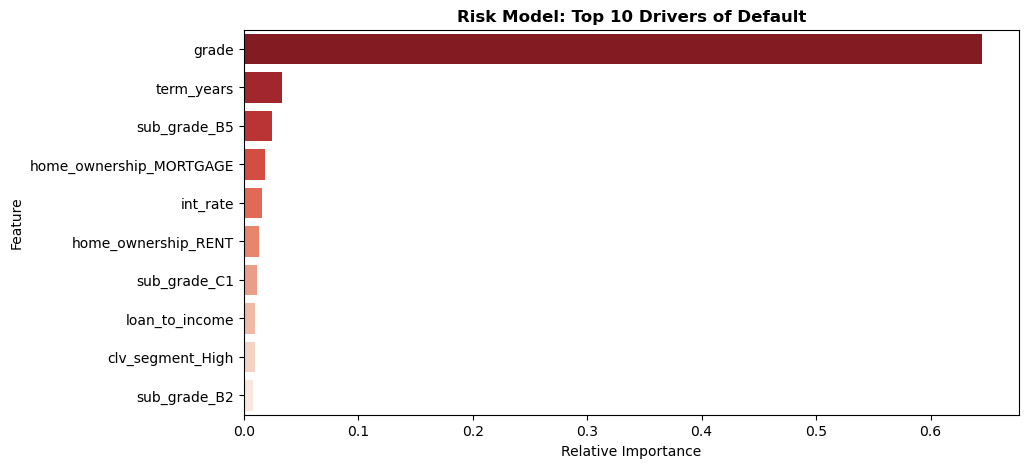

Interpretaion: These are the primary factors the model uses to deny loans or assign high risk.


In [ ]:
risk_model = engine.risk_model
features = risk_model.feature_names_in_

print("=== 🧠 BRAIN 1: RISK MODEL SUMMARY ===")
print(f"Algorithm:   XGBoost Classifier")
print(f"Input Features ({len(features)}): {list(features)}")

# Plot Feature Importance (Proof of Logic)
importance = risk_model.feature_importances_
feat_imp = (
    pd.DataFrame({"Feature": features, "Importance": importance})
    .sort_values("Importance", ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 5))
sns.barplot(data=feat_imp, x="Importance", y="Feature", palette="Reds_r")
plt.title("Risk Model: Top 10 Drivers of Default", fontweight="bold")
plt.xlabel("Relative Importance")
plt.show()

print(
    "Interpretaion: These are the primary factors the model uses to deny loans or assign high risk."
)

## 2. Component Inspection (Elasticity Model)


=== 🧠 BRAIN 2: ELASTICITY MODEL SUMMARY ===
Model Type:  <class 'statsmodels.discrete.discrete_model.BinaryResultsWrapper'>
Intercept:   7.3417

Key Elasticity Coefficients (Price Sensitivity):
          Feature  Coefficient
2   Rate_Subprime   -26.554066
3  Rate_NearPrime   -19.907081
4      Rate_Prime   -22.865577


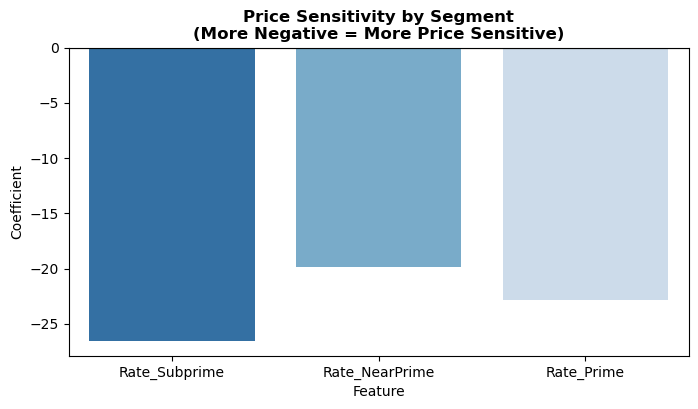

Validation: All Rate coefficients must be NEGATIVE. (Higher Price = Lower Demand).


In [ ]:
# INSPECT BRAIN 2: ELASTICITY MODEL
elast_model = engine.elasticity_model

print("\n=== 🧠 BRAIN 2: ELASTICITY MODEL SUMMARY ===")
print(f"Model Type:  {type(elast_model)}")

params = elast_model.params

intercept_val = params.get("const", 0)
print(f"Intercept:   {intercept_val:.4f}")


coefs = pd.DataFrame({"Feature": params.index, "Coefficient": params.values})


coefs = coefs[coefs["Feature"] != "const"]


print("\nKey Elasticity Coefficients (Price Sensitivity):")
print(coefs[coefs["Feature"].str.contains("Rate")])

# Visual Check of Sensitivity
sensitivity = coefs[coefs["Feature"].str.contains("Rate")]
plt.figure(figsize=(8, 4))
sns.barplot(data=sensitivity, x="Feature", y="Coefficient", palette="Blues_r")
plt.title(
    "Price Sensitivity by Segment\n(More Negative = More Price Sensitive)",
    fontweight="bold",
)
plt.axhline(0, color="black")
plt.show()

print(
    "Validation: All Rate coefficients must be NEGATIVE. (Higher Price = Lower Demand)."
)

## 3. Governance & Policy Configuration

In [ ]:
print("=== 🛡️ BRAIN 3: GOVERNANCE LAYER CONFIG ===")
print("The following hard constraints are applied AFTER optimization:")

config = engine.policy_config
df_config = pd.DataFrame(list(config.items()), columns=["Constraint", "Value"])

# Display nicely
from IPython.display import display, HTML

display(df_config)

print("\nCRITICAL CHECK:")
if config["GLOBAL_MAX_RATE"] > 0.36:
    print("⚠️ WARNING: Global Max Rate exceeds typical Usury Limits (36%)")
else:
    print("✅ PASS: Global Max Rate is within regulatory safety limits.")

=== 🛡️ BRAIN 3: GOVERNANCE LAYER CONFIG ===
The following hard constraints are applied AFTER optimization:


,Constraint,Value
0,GLOBAL_MIN_RATE,0.05
1,GLOBAL_MAX_RATE,0.35
2,MAX_PD_THRESHOLD,0.20
3,PRIME_MAX_RATE,0.20
4,MIN_PROFIT_MARGIN,50.00



CRITICAL CHECK:
✅ PASS: Global Max Rate is within regulatory safety limits.


## 4. Limitations & Assumptions (SR 11-7)
Every model has weaknesses. The following limitations are documented for transparency:

1. Synthetic Elasticity Data:

    * Risk: The "Demand Model" (Brain 2) was trained on synthetic data derived from historical acceptances.
    
    * Mitigation: We assume the generated "Alpha" (Sensitivity) reflects reality. This must be validated via A/B testing in production (Champion/Challenger).

2. Economic Stationarity:

    * Risk: The model assumes the relationship between Income and Default is constant.
    
    * Mitigation: The model does not account for sudden macro-economic shocks (e.g., hyperinflation) unless the pd_multiplier is manually adjusted.

3. Cold Start:

    * Risk: New borrower segments (e.g., "Gig Economy Workers") may not be well-represented in the Prosper training data.
    
    * Mitigation: Governance layer applies strict PD cutoffs (>20%) to reject unknown high-risk profiles.

## 5. Monitoring Plan

To ensure continued reliability, the following metrics will be tracked weekly:

| **Metric** | **Threshold** | **Action if Breached** |
| --- | --- | --- |
| **Population Stability Index (PSI)** | > 0.25 | Retrain Risk Model (Data Drift detected). |
| **Approval Rate** | +/- 10% vs Baseline | Investigate Credit Policy Layer. |
| **Take Rate (Acceptance)** | < 40% | Re-calibrate Elasticity Model (Prices are too high). |
| **Early Payment Default (EPD)** | > 2% | Emergency Stop on Acquisition. |